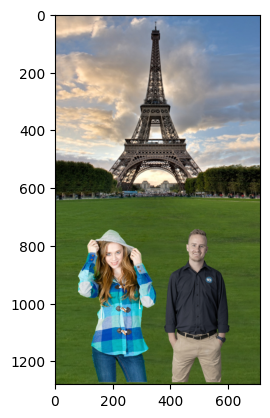

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded


def process_image(BG: np.ndarray, I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    """
    Extracts and enhances the people from two input images (I1, I2) with green screen backgrounds, 
    resizes them proportionally to fit a given background image (BG), and overlays them near the 
    bottom of the background with appropriate positioning and transparency.

    Helper functions: (This is just to avoid repeating the same code for each image)
    extractTransparentPerson extracts a person from an image with a green screen background. Outputs a transparent image.
    enhanceImage enhances the image by adjusting saturation and applying CLAHE to the luminance channel.
    showHistogram displays the histogram of the image.


    Steps:
    Rotation and Green Screen Removal:
        Converts the image to HSV color space and creates a mask for green regions.
        Refine the mask to remove noise using morphological operations.
        Calculates bounding box and calculates its orientation in relation to hortizontal axis.
        Rotates the image to align the object upright and crops it to the bounding box.
        Refines the cropped mask, inverts it, and combines it with the cropped image to add an alpha channel, making the green background transparent.
        
    Enhancing Image:
        Converts the image to HSV and extracts saturation.
        Adjust saturation based on thresholds
        Enhances image by applying CLAHE to the luminance channel.
        Pisano et al. [1] used CLAHE to improve the detection of simulated spiculations in dense mammograms.
        "CLAHE allows you to clip the height of the local historgram and thus on the maximum contrast enhancement factor.
        The enhancement is thereby reduced in very uniform areas of the image which prevents overenhancement of noise and reduces the edge-shadowing effect of unlimited AHE."  (Pisano et al. [1])
        
        
    Scaling and Resizing:
        Resizes the enhanced transparent images to fit into the background image. 
        The height of each resized image is based on the height of the background while maintaining their aspect ratio.

    Positioning:
        Places one image on the left and the other on the right side of the background with padding.

    Overlaying with Transparency:
        Loops over RGB channels to blend each transparent images with the background using their alpha channel.

    Citation:
    [1] E. D. Pisano et al., ‘Contrast Limited Adaptive Histogram Equalization image processing to improve the detection of simulated spiculations in dense mammograms’, J Digit Imaging, vol. 11, no. 4, p. 193, Nov. 1998, doi: 10.1007/BF03178082.


    """
    
    def extractTransparentPerson(I):
        hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 50, 50])
        upper_green = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("No green box found in the image.")
            return
        
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[-1]
        if angle < -45:
            angle += 90
        elif angle > 45:
            angle -= 90
        
        (h, w) = I.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(I, rotation_matrix, (w, h))
        rotated_mask = cv2.warpAffine(mask, rotation_matrix, (w, h))
        
        x, y, w, h = cv2.boundingRect(rotated_mask)
        cropped = rotated_image[y:y+h, x:x+w]
        cropped_mask = rotated_mask[y:y+h, x:x+w]
        
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_OPEN, kernel)
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_CLOSE, kernel)
        
        cropped_mask_inv = cv2.bitwise_not(cropped_mask)
        cropped_alpha = cv2.cvtColor(cropped, cv2.COLOR_BGR2BGRA)
        cropped_alpha[:, :, 3] = cropped_mask_inv
        
        return cropped_alpha
    
    def enhanceImage(img, low_thresh=50, high_thresh=200, target_mean=128):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        
        mean_saturation = np.mean(s)
        
        if mean_saturation < low_thresh:
            scale_factor = target_mean / (mean_saturation + 1e-5)
        elif mean_saturation > high_thresh:
            scale_factor = target_mean / mean_saturation
        else:
            scale_factor = 1.0

        s = np.clip(s * scale_factor, 0, 255).astype(np.uint8)

        adjusted_hsv = cv2.merge((h, s, v))
        
        enhanced_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)
        
        lab = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_l = clahe.apply(l)
        enhanced_lab = cv2.merge((enhanced_l, a, b))
        
        return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    
    transparent_I1 = extractTransparentPerson(I1)
    transparent_I2 = extractTransparentPerson(I2)
    
        
    enhanced_I1 = enhanceImage(I1)
    enhanced_I2 = enhanceImage(I2)
    


    bg_h, bg_w = BG.shape[:2]
    i1_h, i1_w = enhanced_I1.shape[:2]
    i2_h, i2_w = enhanced_I2.shape[:2]
    
    scale_factor_1 = 0.50 * bg_h / i1_h
    scale_factor_2 = 0.50 * bg_h / i2_h
    
    resized_I1 = cv2.resize(transparent_I1, (int(transparent_I1.shape[1] * scale_factor_1), 
                                            int(transparent_I1.shape[0] * scale_factor_1)), 
                                            interpolation=cv2.INTER_AREA)
    resized_I2 = cv2.resize(transparent_I2, (int(transparent_I2.shape[1] * scale_factor_2), 
                                            int(transparent_I2.shape[0] * scale_factor_2)), 
                                            interpolation=cv2.INTER_AREA)

    padding_x = int(0.005 * bg_w)
    padding_y = int(0.005 * bg_h)

    y_offset1 = bg_h - resized_I1.shape[0] - padding_y
    y_offset2 = bg_h - resized_I2.shape[0] - padding_y
    x_offset1 = padding_x
    x_offset2 = bg_w - resized_I2.shape[1] - padding_x

    for c in range(3):
        BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] = \
            BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] * \
            (1 - resized_I1[:, :, 3] / 255.0) + resized_I1[:, :, c] * (resized_I1[:, :, 3] / 255.0)

    for c in range(3):
        BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] = \
            BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] * \
            (1 - resized_I2[:, :, 3] / 255.0) + resized_I2[:, :, c] * (resized_I2[:, :, 3] / 255.0)
    
    BG = cv2.cvtColor(BG, cv2.COLOR_BGRA2RGB)
    
    return BG

# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function


BG = cv2.imread('./background.jpg')
I1 = cv2.imread('./person1.jpg')
I2 = cv2.imread('./person2.jpg')

merged = process_image(BG, I1, I2)

plt.imshow(merged)

